<a href="https://colab.research.google.com/github/Jin-jin-jara/Kaggle-2018-data-science-bowl/blob/master/2018_DataScienceBowl_trial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"layharon","key":"5d7f0fc1fafe5edf323a0e99bb1bd5e5"}'}

In [0]:
!ls -ha kaggle.json

kaggle.json


In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions list

ref                                                                deadline             category             reward  teamCount  userHasEntered  
-----------------------------------------------------------------  -------------------  ---------------  ----------  ---------  --------------  
digit-recognizer                                                   2030-01-01 00:00:00  Getting Started   Knowledge       2401           False  
titanic                                                            2030-01-01 00:00:00  Getting Started   Knowledge      16290            True  
house-prices-advanced-regression-techniques                        2030-01-01 00:00:00  Getting Started   Knowledge       4763           False  
connectx                                                           2030-01-01 00:00:00  Getting Started   Knowledge        458           False  
imagenet-object-localization-challenge                             2029-12-31 07:00:00  Research          Knowledge         65    

In [0]:
!kaggle competitions download -c data-science-bowl-2018

  0% 0.00/112k [00:00<?, ?B/s]
100% 112k/112k [00:00<00:00, 34.0MB/s]
 55% 5.00M/9.10M [00:00<00:00, 22.7MB/s]
100% 9.10M/9.10M [00:00<00:00, 36.1MB/s]
 83% 66.0M/79.1M [00:00<00:00, 42.4MB/s]
100% 79.1M/79.1M [00:01<00:00, 81.6MB/s]
 93% 257M/276M [00:03<00:00, 92.8MB/s]
100% 276M/276M [00:03<00:00, 85.9MB/s]
  0% 0.00/2.67M [00:00<?, ?B/s]
100% 2.67M/2.67M [00:00<00:00, 88.7MB/s]
  0% 0.00/2.62k [00:00<?, ?B/s]
100% 2.62k/2.62k [00:00<00:00, 2.31MB/s]
  0% 0.00/386k [00:00<?, ?B/s]
100% 386k/386k [00:00<00:00, 126MB/s]


In [0]:
!unzip ../content/stage1_train_labels.csv.zip
!unzip ../content/stage1_train.zip -d stage1_train
!unzip ../content/stage1_test.zip -d stage1_test

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: stage1_train/d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0/masks/d8b76279ad8f2e101bb8c5ca95229b6532903eea035ef945dd4a21356d49dead.png  
  inflating: stage1_train/d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0/masks/dc05f946c096c5fcc147024843f21c06c3a94af25d4f37b498ea937953b806fe.png  
  inflating: stage1_train/d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0/masks/e0fd1c4e98bb470bea315e7d8f74396450fe93e93f68e1f8a3443b2b397c8640.png  
  inflating: stage1_train/d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0/masks/e4b6643cafde8ac789b63f7b1a023773960dbe63489963985033619fde052dc9.png  
  inflating: stage1_train/d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0/masks/e7e793a1e1785a41a0432a6cd2137be6e1a448bce9f343cfecb493c699206f82.png  
  inflating: stage1_train/d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0/masks/e893bbfe02a7479b4012b73ea0f

In [0]:
!pip install segmentation_models

In [0]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import skimage.io
import pathlib
from glob import glob
import os
import shutil
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from textwrap import wrap
from skimage.transform import resize
from skimage.filters import threshold_multiotsu
from skimage import filters, data
from skimage.color import rgb2gray
from skimage import transform
import tqdm

# %tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import resnet50
from tensorflow.keras.applications import ResNet101V2
import random
import cv2

import segmentation_models
# sm.set_framword('tf.keras')
from segmentation_models import get_preprocessing
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from segmentation_models import Unet
from keras.optimizers import Adam
from segmentation_models.losses import bce_jaccard_loss, bce_dice_loss, dice_loss
from segmentation_models.metrics import iou_score

np.random.seed(47)
%matplotlib inline

Segmentation Models: using `keras` framework.


Using TensorFlow backend.


In [0]:
STAGE1_TRAIN = "../content/stage1_train"
STAGE1_TRAIN_IMAGE = "%s/{}/images/{}.png" % STAGE1_TRAIN
STAGE1_TRAIN_MASK = "%s/{}/masks/*.png" % STAGE1_TRAIN
IMAGE_ID = "image_id"
IMAGE_WIDTH = "width"
IMAGE_WEIGHT = "height"
HSV_CLUSTER = "hsv_cluster"
HSV_DOMINANT = "hsv_dominant"
TOTAL_MASK = "total_masks"

기본적 전처리 함수들

In [0]:
# 이미지의 id를 리턴
def image_ids_in(root_dir, ignore=[]):
  ids = []
  for id in os.listdir(root_dir):
    if id in ignore:
      print("Skipping ID:", id)
    else:
      ids.append(id)
  return ids

# 이미지를 읽어온다. 하나씩
def read_image(image_id, space='rgb'):
  image_file = STAGE1_TRAIN_IMAGE.format(image_id, image_id)
  image = skimage.io.imread(image_file) 
  image = image[:, :, :3]
  if space=='hsv':
    # HSV = rgb2hsv(RGB)는 RGB 이미지의 빨간색, 녹색, 파란색 값을 HSV 이미지의 색상, 채도, 명도(HSV) 값으로 변환합니다.
    image = skimage.color.rgb2hsv(image)
  return image

# 각 이미지에 대한 마스크를 가져온다. 이미지와 합쳐진 마스크를 리턴
def read_image_labels(image_id, space='rgb'):
  image = read_image(image_id, space=space)
  mask_file = STAGE1_TRAIN_MASK.format(image_id)
  masks = skimage.io.imread_collection(mask_file).concatenate()
  height, width, _ = image.shape
  num_masks = masks.shape[0]
  labels = np.zeros((height, width), np.uint16)
  for index in range(0, num_masks):
    labels[masks[index] > 0] = 255
  return image, labels, num_masks


def plot_images(images, images_rows, images_cols):
  f, axarr = plt.subplots(images_rows, images_cols, figsize=(16, images_rows*2))
  for row in range(images_rows):
    for col in range(images_cols):
      image_id = images[row*images_cols + col]
      image = read_image(image_id)
      height, width, l = image.shape
      ax = axarr[row, col]
      ax.axis('off')
      ax.set_title("%dx%d"%(width, height))
      ax.imshow(image)

# 이미지를 원하는 사이즈로 바꾼다.
def resize_images(train_id, image_size, space="rgb"):
  img, labels, num_masks = read_image_labels(train_id, space=space)
  resized_img = resize(img, (image_size, image_size), preserve_range=True, mode='constant').astype(np.uint8) 
  resized_masks = resize(labels, (image_size, image_size), mode='constant', preserve_range=True).astype(np.uint8)
  return resized_img, resized_masks


def resized_plot_images(images, images_rows, images_cols):
  f, axarr = plt.subplots(images_rows, images_cols, figsize=(16, images_rows*2))
  for row in range(images_rows):
    for col in range(images_cols):
      image_id = images[row*images_cols + col]
      image,_ = resize_images(image_id)
      height, width, l = image.shape
      ax = axarr[row, col]
      ax.axis('off')
      ax.set_title("%dx%d"%(width, height))
      ax.imshow(image)

In [0]:
train_image_ids = image_ids_in(STAGE1_TRAIN)

In [0]:
X_train, y_train = [], []
for id in train_image_ids:
  img, mask = resize_images(id, image_size=256)
  X_train.append(img)
  y_train.append(mask)
X_train = np.array(X_train)
y_train = np.array(y_train)
y_train.shape

(670, 256, 256)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test,  y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2)

In [0]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((536, 256, 256, 3), (536, 256, 256), (134, 256, 256, 3), (134, 256, 256))

입력 데이터가 준비되었으므로 이미지와 마스크를 확인한다.

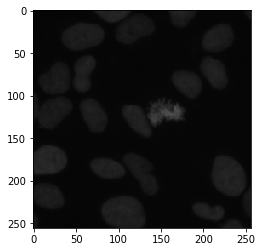

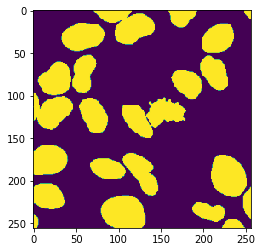

In [0]:
plt.imshow(X_train[0])
plt.show()
plt.imshow(y_train[0])
plt.show()

## build model

In [0]:
IMG_HEIGHT =256
IMG_WIDTH = 256
IMG_CHANNELS = 3

아직은 사용 이유를 잘 모르겠음.

In [0]:
BACKBONE = 'resnet101'
preprocess_input = get_preprocessing(BACKBONE)

파이프라인 generator 클래스 생성<br>
albumentations : 데이터 augmentation을 튜닝할 수 있는 라이브러리. 파이프라인 generator를 만들어 사용한다. 이 파이프라인의 기본 함수는 __init__, __len__, __getitem__, getitem에서 대부분의 기능을 수행한다. 나머지 함수들은 편의를 위해 추가한 것

In [0]:
from keras.utils import Sequence
from skimage.io import imread
import os
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.ERROR)
%load_ext autoreload
%autoreload 2
%matplotlib inline
from albumentations import (Blur, Compose, HorizontalFlip, HueSaturationValue,
                            IAAEmboss, IAASharpen, JpegCompression, OneOf,
                            RandomBrightness, RandomBrightnessContrast,
                            RandomContrast, RandomCrop, RandomGamma,
                            RandomRotate90, RGBShift, ShiftScaleRotate,
                            Transpose, VerticalFlip, ElasticTransform, GridDistortion, OpticalDistortion)
 
import albumentations as albu
from albumentations import Resize

# 사실 이 클래스를 만들면서 image를 resize하기 때문에 위에서 resize안해줘도 된다.
# 나중에 고칠 것
class MyGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size, augmentation=None):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.augment = augmentation
        self.image_size = 256
        self.indice = None
        self.shuffle = shuffle
        
    def __len__(self):
        """
        Calculates size of batch
        """
        return int(np.ceil(len(self.x) / (self.batch_size)))
    
    # 매 에포크마다 전체 데이터를 shuffle해준다.
    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle==True:
            self.x, self.y = shuffle(self.x, self.y)

    def read_image_mask(self, img, mask):
        return img, rgb2gray(mask).astype(np.uint8)

    #
    def __getitem__(self, index):
        """
        Generate one batch of data
        
        """
        # Generate indexes of the batch
        data_index_min = int(index*self.batch_size)
        data_index_max = int(min((index+1)*self.batch_size, len(self.x)))
        
        indice = self.x[data_index_min:data_index_max]

        this_batch_size = len(indice) # The last batch can be smaller than the others
        
        # Defining dataset
        X = np.empty((this_batch_size, self.image_size, self.image_size, 3), dtype=np.uint8)
        Y = np.empty((this_batch_size, self.image_size, self.image_size, 1), dtype=np.uint8)

        for i, sample_index in enumerate(indice):

            X_sample, y_sample = self.read_image_mask(self.x[index * self.batch_size + i], self.y[index * self.batch_size + i])
                 
            # if augmentation is defined, we assume its a train set
            if self.augment is not None:
                  
                # Augmentation code
                augmented = self.augment(self.image_size)(image=X_sample, mask=y_sample)
                image_augm = augmented['image']
                mask_augm = augmented['mask'].reshape(self.image_size, self.image_size, 1)
                # X[i, ...] = np.clip(image_augm, a_min = 0, a_max=1)
                X[i, ...] = image_augm
                Y[i, ...] = mask_augm
            
            # if augmentation is not defined, we assume its a test set. 
            # Because test images can have different sizes we resize it to be divisable by 32
            elif self.augmentation is None and self.batch_size ==1:
                X_sample, y_sample = self.image_filenames[index * 1 + i], self.mask_names[index * 1 + i]
                augmented = self.augment(image = X_sample, mask = y_sample)
                X_sample, y_sample = augmented['image'], augmented['mask']

                return preprocess_input(X_sample.reshape(1, X_sample.shape[0], X_sample.shape[1], 3).astype(np.uint8)),\
                       y_sample.reshape(1, X_sample.shape[0], X_sample.shape[1], 1).astype(np.uint8)
        # label에 정규화를 안했더니 안들어간다. 주의하자
        return preprocess_input(X), Y[:,:,:,:1]/255

데이터 augmentation 함수 만들기

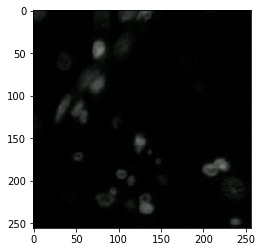

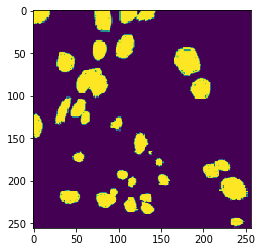

In [0]:
# 데이터 augmentation 함수 : 원하는 필터를 넣으면 된다. p는 확률
# 다양한 방법의 필터와 데이터 증식을 적용시킬 수 있는데 Flip이나 Rotate은 안하는게 성능적인 면에서 더 낫다.
# ChannelShuffle도 임포트해서 적용해볼 것(좋다고 한다 1등이)
def augmentation(image_size = 256):
    return Compose([
        # HorizontalFlip(p=1),
        # VerticalFlip(p=1),
        # RandomRotate90(p=1),
        IAASharpen(p=1),
        RandomContrast(p=1),
        # Transpose(p=0.5),
        # ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
        RandomBrightnessContrast(p=1),
        RandomGamma(p=1),
        IAAEmboss(p=1),
        RGBShift(p=0.5),
        Blur(p=1, blur_limit = 3),
        OneOf([
            ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
            GridDistortion(p=0.5),
            OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)                  
        ], p=0.8)
    ], p = 1)

# 함수와 파이프라인이 잘 작동되는지 테스트, 사진이 정상적으로 뜨면 성공
batch_size=16
test_generator = MyGenerator(X_train, y_train, batch_size, augmentation = augmentation)
Xtest, ytest = test_generator.__getitem__(1)
# 테스트 이미지
plt.imshow(Xtest[0])     
plt.show()
# 테스트 마스크
plt.imshow(ytest[0, :,:,0])
plt.show()

테스트의 shape을 확인

In [0]:
Xtest.shape, ytest.shape

((16, 256, 256, 3), (16, 256, 256, 1))

train generator와 test generator를 생성 batch size는 16으로 설정

In [0]:
BATCH_SIZE = 16
train_gen = MyGenerator(X_train, y_train, BATCH_SIZE, augmentation=augmentation)
test_gen = MyGenerator(X_test, y_test, BATCH_SIZE, augmentation=augmentation)

In [0]:
# plateau는 정체기란 뜻으로 모델의 정확도가 향상되지 않는 경우 ㅡ learning rate (lr) 을 줄여주는 클래스
lr_reducer = ReduceLROnPlateau(factor=0.1,
                               cooldown=10,
                               patience=10, verbose=1,
                               min_lr=0.1e-5)

# ModelCheckpoint 콜백 함수는 Keras에서 모델을 학습할 때마다 중간중간에 콜백 형태로 알려준다.
# 학습 과정 중 콜백을 사용해서 모델의 내적 상태와 통계자료를 확인 할 수 있다
# 주석처리 한 이유는 모델의 가중치를 중간중간 저장해주는게 오래걸려서 나중에 주석을 풀고 사용하자
# mode_autosave = ModelCheckpoint("content/resnet101.h5", monitor='val_iou_score',
#                                 mode='max', save_best_only=True, verbose=1, period=10)

early_stopping = EarlyStopping(patience=10, verbose=1, mode='auto')

# TensorBoard는 TensorFlow에 기록된 로그를 그래프로 시각화시켜서 보여주는 도구
# 주석처리한 이유는 위와 같다 지금은 굳이 저장할 필요 없어서
# tensorboard = TensorBoard(log_dir='content/tensorboard', histogram_freq=0,
#                           write_graph=True, write_images=False)

callbacks = [lr_reducer, early_stopping]

## model1 : augmentation no flip

Epoch 1/30
34/34 [==============================] - 47s 1s/step - loss: 0.8840 - iou_score: 0.3178 - val_loss: 0.8823 - val_iou_score: 0.3391

Epoch 2/30
34/34 [==============================] - 12s 348ms/step - loss: 0.4338 - iou_score: 0.5547 - val_loss: 0.4358 - val_iou_score: 0.5567
Epoch 3/30
34/34 [==============================] - 13s 379ms/step - loss: 0.3341 - iou_score: 0.6487 - val_loss: 0.6053 - val_iou_score: 0.4670
Epoch 4/30
34/34 [==============================] - 13s 374ms/step - loss: 0.3001 - iou_score: 0.6847 - val_loss: 0.4573 - val_iou_score: 0.5598
Epoch 5/30
34/34 [==============================] - 12s 361ms/step - loss: 0.2863 - iou_score: 0.7021 - val_loss: 0.3517 - val_iou_score: 0.6439
Epoch 6/30
34/34 [==============================] - 13s 372ms/step - loss: 0.2648 - iou_score: 0.7221 - val_loss: 0.3133 - val_iou_score: 0.6804
Epoch 7/30
34/34 [==============================] - 13s 373ms/step - loss: 0.2511 - iou_score: 0.7334 - val_loss: 0.3383 - val_iou_s

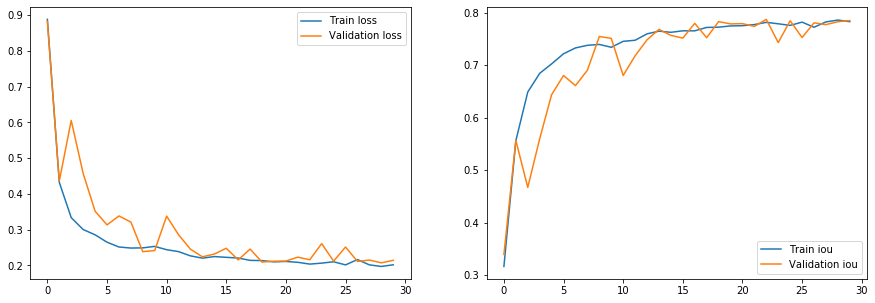

In [0]:
# train데이터와 vailadation 데이터의 손실값, iou점수를 시각화하는 함수
def plot_training_history(history):
  fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15, 5))
  ax_loss.plot(history.epoch, history.history['loss'], label="Train loss")
  ax_loss.plot(history.epoch, history.history['val_loss'], label="Validation loss")
  ax_loss.legend()
  ax_acc.plot(history.epoch, history.history["iou_score"], label="Train iou")
  ax_acc.plot(history.epoch, history.history['val_iou_score'], label="Validation iou")
  ax_acc.legend()

# Unet모델. 전이학습 모델로는 resnet101을 사용
model = Unet(backbone_name='resnet101', encoder_weights='imagenet', encoder_freeze=True, decoder_use_batchnorm=True,)
model.compile(optimizer = Adam(),
              loss = bce_dice_loss, metrics=[iou_score])
history = model.fit_generator(train_gen, shuffle=True,
                              epochs=30, workers=4, use_multiprocessing=True,
                              validation_data = test_gen,
                              verbose=1, callbacks=callbacks)
# 
plot_training_history(history)

### model quality check
모델의 성능을 측정해보자<br>
1) 하나의 이미지에 대한 모델 성능 측정

In [0]:
# iou 성능 평가 지표를 만든다.
def iou_metric(y_true_in, y_pred_in):
  labels = y_true_in
  y_pred = y_pred_in

  temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins = ([0,0.5,1],[0, 0.5, 1]))
  
  intersection = temp1[0]

  area_true = np.histogram(labels, bins = [0, 0.5,1])[0]
  area_pred = np.histogram(y_pred, bins=[0, 0.5, 1])[0]
  area_true = np.expand_dims(area_true, -1)
  area_pred = np.expand_dims(area_pred, 0)

  union = area_true + area_pred - intersection

  intersection = intersection[1:, 1:]
  intersection[intersection == 0] = 1e-9

  union = union[1:, 1:]
  union[union == 0] = 1e-9

  iou = intersection / union
  return iou

# , 예측한 이미지,label(mask, 즉 정답), 원본 이미지를 보여주는 함수
def plot_mask_gt_image(mask, groud_truth, img):
  fig, axs = plt.subplots(1, 3, figsize=(20, 10))
  axs[0].imshow(mask, cmap='Blues')
  axs[1].imshow(groud_truth, cmap="Blues")
  axs[2].imshow(img)
  plt.show()


def iou_metric_batch(y_true_in, y_pred_in):
  y_pred_in = y_pred_in
  batch_size = y_true_in.shape[0]
  metric = []
  for batch in range(batch_size):
    value = iou_metric(y_true_in[batch], y_pred_in[batch])
    metric.append(value)
  return np.mean(metric)

# 테스트용 generator로 아무거나 꺼내와서 정확도 측정
Xtest, ytest = test_generator.__getitem__(1)
predicted = model.predict(np.expand_dims(Xtest[0], axis=0))
print('IOU', iou_metric(ytest[0], predicted))

IOU [[0.86289952]]


In [0]:
# 한 번더 테스트용 generator로 아무거나 꺼내와서 정확도 측정
Xtest, ytest = test_generator.__getitem__(16)
predicted = model.predict(np.expand_dims(Xtest[0], axis=0)).reshape(256, 256)
print('IOU', iou_metric(ytest[0], predicted))

IOU [[0.7164541]]


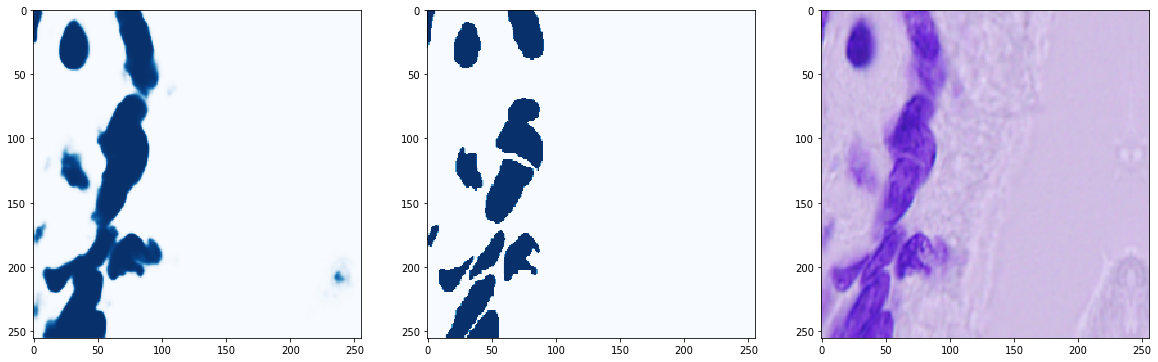

In [0]:
# 순서대로 예측한 이미지, 정답 label, 원본 이미지
plot_mask_gt_image(predicted, ytest[0].squeeze(-1), Xtest[0])

## model2 : augmentaion flip, rotate (horizontal, vertical, rotate)

In [0]:
# 데이터 augmentation 함수 : 원하는 필터를 넣으면 된다. p는 확률
# 다양한 방법의 필터와 데이터 증식을 적용시킬 수 있는데 Flip이나 Rotate은 안하는게 성능적인 면에서 더 낫다.
# ChannelShuffle도 임포트해서 적용해볼 것(좋다고 한다 1등이)
def augmentation(image_size = 256):
    return Compose([
        HorizontalFlip(p=1),
        VerticalFlip(p=1),
        RandomRotate90(p=1),
        IAASharpen(p=1),
        RandomContrast(p=1),
        # Transpose(p=0.5),
        # ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
        RandomBrightnessContrast(p=1),
        RandomGamma(p=1),
        IAAEmboss(p=1),
        RGBShift(p=0.5),
        Blur(p=1, blur_limit = 3),
        OneOf([
            ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
            GridDistortion(p=0.5),
            OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)                  
        ], p=0.8)
    ], p = 1)

# 함수와 파이프라인이 잘 작동되는지 테스트, 사진이 정상적으로 뜨면 성공
batch_size=16
test_generator = MyGenerator(X_train, y_train, batch_size, augmentation = augmentation)
Xtest, ytest = test_generator.__getitem__(1)
# 테스트 이미지
plt.imshow(Xtest[0])     
plt.show()
# 테스트 마스크
plt.imshow(ytest[0, :,:,0])
plt.show()

Epoch 1/30
34/34 [==============================] - 52s 2s/step - loss: 0.9056 - iou_score: 0.2982 - val_loss: 1.3571 - val_iou_score: 0.2567
Epoch 1/30
Epoch 2/30
34/34 [==============================] - 12s 355ms/step - loss: 0.4245 - iou_score: 0.5637 - val_loss: 0.4467 - val_iou_score: 0.5464
Epoch 3/30
34/34 [==============================] - 13s 381ms/step - loss: 0.3490 - iou_score: 0.6357 - val_loss: 0.4274 - val_iou_score: 0.5774
Epoch 3/30
Epoch 4/30
34/34 [==============================] - 13s 395ms/step - loss: 0.3114 - iou_score: 0.6741 - val_loss: 0.5078 - val_iou_score: 0.5256
Epoch 5/30
34/34 [==============================] - 13s 385ms/step - loss: 0.2959 - iou_score: 0.6936 - val_loss: 0.3719 - val_iou_score: 0.6239
Epoch 6/30
34/34 [==============================] - 13s 380ms/step - loss: 0.2697 - iou_score: 0.7184 - val_loss: 0.6780 - val_iou_score: 0.5500
Epoch 7/30
34/34 [==============================] - 13s 384ms/step - loss: 0.2579 - iou_score: 0.7282 - val_los

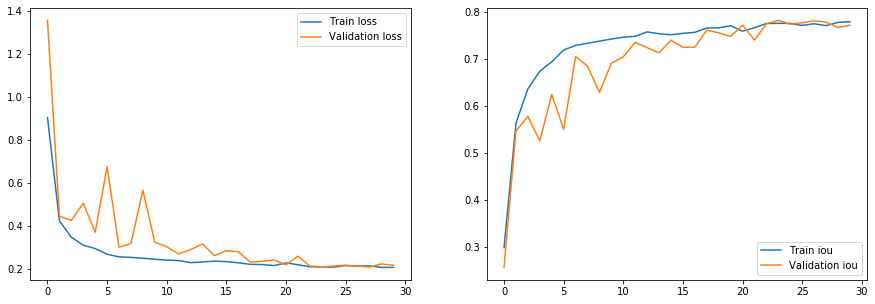

In [0]:
# train데이터와 vailadation 데이터의 손실값, iou점수를 기록하는 함수
def plot_training_history(history):
  fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15, 5))
  ax_loss.plot(history.epoch, history.history['loss'], label="Train loss")
  ax_loss.plot(history.epoch, history.history['val_loss'], label="Validation loss")
  ax_loss.legend()
  ax_acc.plot(history.epoch, history.history["iou_score"], label="Train iou")
  ax_acc.plot(history.epoch, history.history['val_iou_score'], label="Validation iou")
  ax_acc.legend()

# Unet모델. 전이학습 모델로는 resnet101을 사용
model = Unet(backbone_name='resnet101', encoder_weights='imagenet', encoder_freeze=True, decoder_use_batchnorm=True,)
model.compile(optimizer = Adam(),
              loss = bce_dice_loss, metrics=[iou_score])
history = model.fit_generator(train_gen, shuffle=True,
                              epochs=30, workers=4, use_multiprocessing=True,
                              validation_data = test_gen,
                              verbose=1, callbacks=callbacks)
# 
plot_training_history(history)

In [0]:
def iou_metric(y_true_in, y_pred_in):
  labels = y_true_in
  y_pred = y_pred_in

  temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins = ([0,0.5,1],[0, 0.5, 1]))
  
  intersection = temp1[0]

  area_true = np.histogram(labels, bins = [0, 0.5,1])[0]
  area_pred = np.histogram(y_pred, bins=[0, 0.5, 1])[0]
  area_true = np.expand_dims(area_true, -1)
  area_pred = np.expand_dims(area_pred, 0)

  union = area_true + area_pred - intersection

  intersection = intersection[1:, 1:]
  intersection[intersection == 0] = 1e-9

  union = union[1:, 1:]
  union[union == 0] = 1e-9

  iou = intersection / union
  return iou

def plot_mask_gt_image(mask, groud_truth, img):
  fig, axs = plt.subplots(1, 3, figsize=(20, 10))
  axs[0].imshow(mask, cmap='Blues')
  axs[1].imshow(groud_truth, cmap="Blues")
  axs[2].imshow(img)
  plt.show()

def iou_metric_batch(y_true_in, y_pred_in):
  y_pred_in = y_pred_in
  batch_size = y_true_in.shape[0]
  metric = []
  for batch in range(batch_size):
    value = iou_metric(y_true_in[batch], y_pred_in[batch])
    metric.append(value)
  return np.mean(metric)

Xtest, ytest = test_generator.__getitem__(1)
predicted = model.predict(np.expand_dims(Xtest[0], axis=0))
print('IOU', iou_metric(ytest[0], predicted))

IOU [[0.7025472]]


In [0]:
Xtest, ytest = test_generator.__getitem__(16)
predicted = model.predict(np.expand_dims(Xtest[0], axis=0)).reshape(256, 256)
print('IOU', iou_metric(ytest[0], predicted))

IOU [[0.68073574]]


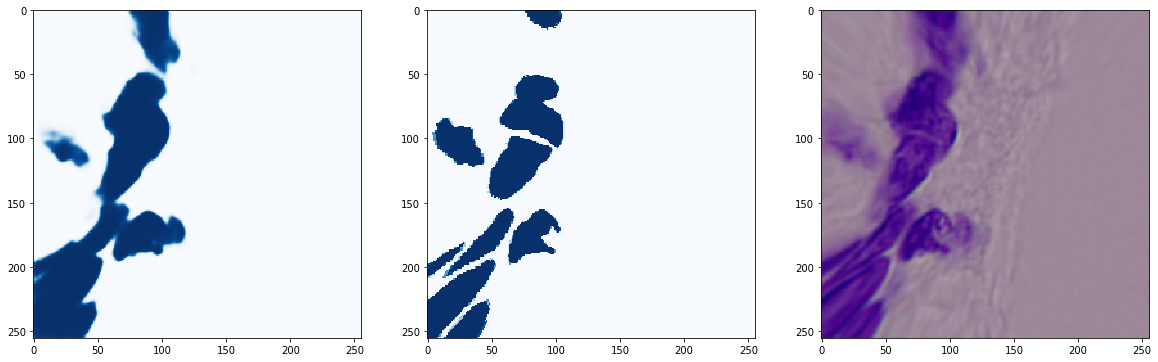

In [0]:
plot_mask_gt_image(predicted, ytest[0].squeeze(-1), Xtest[0])

## model3 : no flip, loss = dice_loss, epoch = 50

Epoch 1/50
33/34 [============================>.] - ETA: 1s - loss: 0.5400 - iou_score: 0.3047Epoch 1/50
Epoch 1/50
34/34 [==============================] - 68s 2s/step - loss: 0.5383 - iou_score: 0.3060 - val_loss: 0.5980 - val_iou_score: 0.2521
Epoch 2/50
34/34 [==============================] - 13s 373ms/step - loss: 0.3091 - iou_score: 0.5304 - val_loss: 0.3642 - val_iou_score: 0.4668
Epoch 3/50
34/34 [==============================] - 13s 386ms/step - loss: 0.2152 - iou_score: 0.6473 - val_loss: 0.2663 - val_iou_score: 0.5824
Epoch 4/50
Epoch 3/50
34/34 [==============================] - 14s 409ms/step - loss: 0.1724 - iou_score: 0.7068 - val_loss: 0.2154 - val_iou_score: 0.6476
Epoch 4/50
Epoch 5/50
34/34 [==============================] - 13s 391ms/step - loss: 0.1598 - iou_score: 0.7259 - val_loss: 0.1752 - val_iou_score: 0.7023
Epoch 6/50
34/34 [==============================] - 14s 412ms/step - loss: 0.1594 - iou_score: 0.7260 - val_loss: 0.1458 - val_iou_score: 0.7462
Epoch 

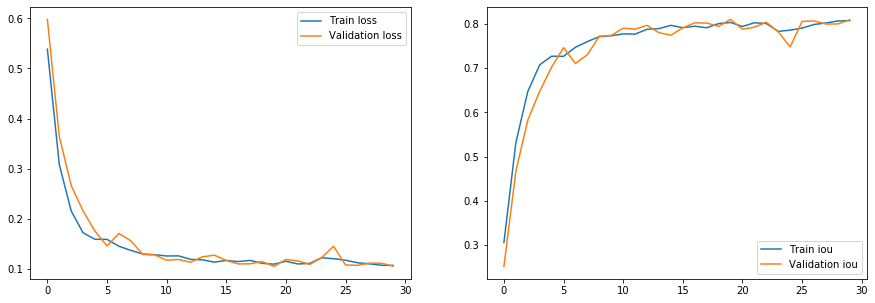

In [0]:
# train데이터와 vailadation 데이터의 손실값, iou점수를 기록하는 함수
def plot_training_history(history):
  fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15, 5))
  ax_loss.plot(history.epoch, history.history['loss'], label="Train loss")
  ax_loss.plot(history.epoch, history.history['val_loss'], label="Validation loss")
  ax_loss.legend()
  ax_acc.plot(history.epoch, history.history["iou_score"], label="Train iou")
  ax_acc.plot(history.epoch, history.history['val_iou_score'], label="Validation iou")
  ax_acc.legend()

# Unet모델. 전이학습 모델로는 resnet101을 사용
model = Unet(backbone_name='resnet101', encoder_weights='imagenet', encoder_freeze=True, decoder_use_batchnorm=True,)
model.compile(optimizer = Adam(),
              loss = dice_loss, metrics=[iou_score])
history = model.fit_generator(train_gen, shuffle=True,
                              epochs=50, workers=4, use_multiprocessing=True,
                              validation_data = test_gen,
                              verbose=1, callbacks=callbacks)
# 
plot_training_history(history)

In [0]:
def iou_metric(y_true_in, y_pred_in):
  labels = y_true_in
  y_pred = y_pred_in

  temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins = ([0,0.5,1],[0, 0.5, 1]))
  
  intersection = temp1[0]

  area_true = np.histogram(labels, bins = [0, 0.5,1])[0]
  area_pred = np.histogram(y_pred, bins=[0, 0.5, 1])[0]
  area_true = np.expand_dims(area_true, -1)
  area_pred = np.expand_dims(area_pred, 0)

  union = area_true + area_pred - intersection

  intersection = intersection[1:, 1:]
  intersection[intersection == 0] = 1e-9

  union = union[1:, 1:]
  union[union == 0] = 1e-9

  iou = intersection / union
  return iou

def plot_mask_gt_image(mask, groud_truth, img):
  fig, axs = plt.subplots(1, 3, figsize=(20, 10))
  axs[0].imshow(mask, cmap='Blues')
  axs[1].imshow(groud_truth, cmap="Blues")
  axs[2].imshow(img)
  plt.show()

def iou_metric_batch(y_true_in, y_pred_in):
  y_pred_in = y_pred_in
  batch_size = y_true_in.shape[0]
  metric = []
  for batch in range(batch_size):
    value = iou_metric(y_true_in[batch], y_pred_in[batch])
    metric.append(value)
  return np.mean(metric)

Xtest, ytest = test_generator.__getitem__(1)
predicted = model.predict(np.expand_dims(Xtest[0], axis=0))
print('IOU', iou_metric(ytest[0], predicted))

IOU [[0.83284732]]


In [0]:
Xtest, ytest = test_generator.__getitem__(23)
predicted = model.predict(np.expand_dims(Xtest[0], axis=0)).reshape(256, 256)
print('IOU', iou_metric(ytest[0], predicted))

IOU [[0.69001098]]


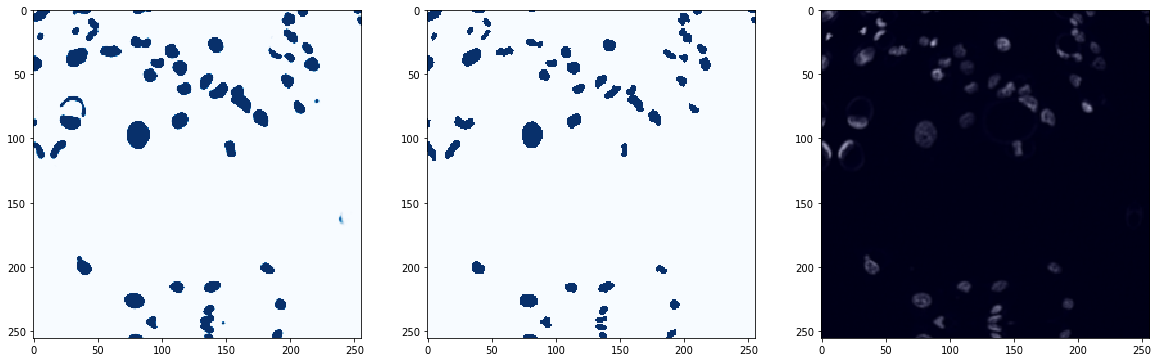

In [0]:
plot_mask_gt_image(predicted, ytest[0].squeeze(-1), Xtest[0])

## model 결론
1) Flip이나 Rotate은 안하는게 성능적인 면에서 더 낫다.<br>
2) loss function으론 bce_dice_loss랑 dice_loss 둘 다 비슷한 성능인 것 같은데 bce_dice_loss가 미묘하게 더 좋은 것 같다.<br>
다른 것도 좀 더 실험해보자

아래 부분은 전체적인 이미지에 대한 모델 성능 측정. 미완

In [0]:
scores = model.evaluate_generator(test_generator)
metrics=[iou_score]
print('Loss:{:.5}'.format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
  print("mean {}: {:.5}".format(metric.__name__, value))

Loss:0.10605
mean iou_score: 0.80879


In [0]:
def draw_get_best_threshold(ious, thresholds):
  threshold_best_index = np.argmax(ious)
  iou_best = ious[threshold_best_index]
  threshold_best = thresholds[threshold_best_index]

  plt.plot(thresholds, ious)
  plt.plot(threshold_best, iou_best, 'xr', label = 'Best threshold')
  plt.xlabel('Threshold')
  plt.ylabel('IoU')
  plt.title('threshold vs IoU({}, {})'.format(threshold_best, iou_best))
  plt.legend()
  return threshold_best, iou_best

preds = []
y_val = []

for i in (range(0, test_generator.__len__())):
  Xtest, ytest = test_generator.__getitem__(i)
  preds.append(tta)